

#### HDBSCAN의 검증(Validation)에 대하여

클러스터링은 매우 어려운 문제인데, 그 이유는 레이블이 존재하지 않을 때 '정답'이라고 할 만한 답이 실제로 없기 때문이다.

이 문제는 각종 기법들이 여러 전제를 가지고 있기 때문에 더 복잡해진다. 만약 어떤 기법을 잘못 적용해서 이 전제를 위배한다면, 결과도 잘못(아주 심각하게 잘못) 나오게 된다.

이 블로그 글에서는 클러스터링이 왜 복잡해지는지에 대해 간략히 다루고, [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan)에서 밀도 기반 클러스터를 제대로 튜닝하는 방법에 대해 깊이 있게 살펴볼 것이다.

*참고: 2023년 11월 업데이트 – 이 노트북의 순서가 변경되었는데, DenseClus는 주어진 하이퍼파라미터에 대해 최적의 메트릭 값에 수렴하기 때문이다. 이제 먼저 튜닝을 한 후 DenseClus를 호출한다.*

---

#### 배경: 클러스터링은 복잡하다

클러스터링 알고리즘에는 [No Free Lunch(무료 점심은 없다)](https://en.wikipedia.org/wiki/No_free_lunch_theorem) 법칙이 적용된다. 어떤 알고리즘이 특정 데이터셋에서는 잘 작동할 수 있지만, 동일한 방식으로 다른 데이터셋에서 잘 작동한다는 보장은 없다. 마찬가지로, 클러스터링은 "연구자의 맥락, 목표, 그리고 판단에 강하게 의존한다." 이는 Henning이 [What Are True Clusters? Henning 2015](https://arxiv.org/abs/1502.02555)에서 지적했듯이, "자연스러운 군집을 무조건 잘 찾아주는 보편적인 최적 방법은 없다"는 주장을 더 강하게 만든다.

예를 들어, 흔히 사용되는 KMeans와 같은 기법들은 데이터가 수치형이고 구(sphere) 형태의 분포를 가진다는 것을 전제로 한다. 이런 전제는 데이터의 차원이 높고 범주형 값이 포함되어 있을 때는 잘 맞지 않는다.

전제를 위반하는 데이터로 클러스터링을 하면, 실무자는 두 가지 난관에 부딪히게 된다.

1. 어떤 특성화(피처리제이션) 방식을 공식화할 것인가?
2. 어떤 클러스터링 기법을 선택할 것인가?

이 두 가지 모두, 전제를 위반하지 않도록 공식화되어야 한다. 실제로는, 알고리즘과 피처리제이션 방식이 전제를 위반하지 않는 경우만이 선택지로 남는, 일종의 소거법의 과정을 거치게 된다.

---

#### 당신의 평가 메트릭을 조심하라

레이블이 없는 경우에는, [실루엣 점수(Silhouette Score)](https://en.wikipedia.org/wiki/Silhouette_%28clustering%29)와 같은 객관적 메트릭을 사용해서 평가하고, 최종 클러스터링 결과를 결정하는 것이 흔하다. 실루엣 점수는 군집의 응집도(cohesiveness)와 분리도(separation)를 -1에서 1 사이의 지수로 측정한다. 하지만 이 메트릭은 **지수 계산에 노이즈를 포함하지 않고, 거리를 활용한다**. 거리는 밀도 기반 클러스터링 기법에는 적합하지 않다. **객관적 메트릭 계산에서 노이즈를 포함하지 않는 것은, 밀도 기반 클러스터링의 본질적 전제를 위반하는 것이다.**

**이 말은, 실루엣 점수와 그와 유사한 지표들은 밀도 기반 기법의 성능을 측정하는 데 부적절하다는 뜻이다!!!**
(내가 강조하는 이유는, 이 블로그에서 여러 번 이런 잘못된 사례를 봤기 때문이다. 이것은 위험하다.)

---

#### 밀도 기반 클러스터링 평가(Validation)의 등장

밀도 기반 클러스터링 평가(Density Based Clustering Validation, DBCV)는, **밀도 기반 클러스터링 알고리즘**에 대해서는 정확히 노이즈를 고려하고, 군집의 모양 특성을 거리 대신 밀도를 통해 포착하기 때문에 잘 작동한다 (자세한 내용은 [원 논문](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf) 참고).

논문에서 설명하는 바에 따르면, DBCV의 최종 결과는 클러스터별 “타당성 지수(Validity Index)” 값의 가중합(weighted sum)이다. 이로부터 -1에서 1 사이의 점수가 산출되며, **값이 클수록 클러스터링 솔루션이 더 우수**하다는 뜻이다.

출처: Density-Based Clustering Validation, Moulavi et al. 2014

자세한 논의는 여기서 다루지 않지만, 자세한 내용은 원 논문을 참고하라.

DBCV 역시 [단점](https://github.com/scikit-learn-contrib/hdbscan/issues/283)이 있다. 앞서 언급한 것처럼, 모든 평가 지표와 기법들이 그렇듯 DBCV도 클러스터링에서의 복잡성과 측정의 문제에서 자유롭지 않다.

그럼에도, 실제 정답 레이블(groundtruth)이 없는 상황에서 **밀도 기반 기법의 클러스터가 얼마나 잘 분리되었는지**를 판단할 수 있는 객관적인 기준을 제공한다.

---

## 예시

설명은 이 정도로 하고, 이제 실제 예시로 들어가보자.

[노트북](https://github.com/awslabs/amazon-denseclus/blob/main/notebooks/Tuning%20with%20HDBSCAN.ipynb)은 [Amazon Denseclus 라이브러리](https://github.com/awslabs/amazon-denseclus)에 포함되어 있다.

이 예제에서는 가상의 통신회사에 대한 합성 이탈(Churn) 데이터셋을 사용할 것이다. 여기서 결과 변수인 Churn?은 True(이탈) 또는 False(이탈하지 않음)로 플래그가 설정되어 있다. 특성은 고객의 요금제와 사용량 정보 등 고객 관련 상세정보를 포함한다. 이 이탈 데이터셋은 공개 데이터셋으로, [Discovering Knowledge in Data by Daniel T. Larose](https://www.amazon.com/dp/0470908742/)라는 책에 언급되어 있으며, 저자는 이 데이터셋이 University of California Irvine(UC Irvine) 머신러닝 데이터셋 저장소에 속한다고 밝혔다.

이 데이터에는 수치형과 범주형 특성이 모두 포함되어 있지만, Denseclus를 사용해 저차원, 조밀한 공간으로 변환하여 클러스터를 형성한다. DenseClus에 대한 자세한 내용은 [여기](https://aws.amazon.com/blogs/opensource/introducing-denseclus-an-open-source-clustering-package-for-mixed-type-data/)에서 볼 수 있다. 필요한 모든 변환은 내부적으로 처리된다. 사용자는 단순히 `fit`만 호출하면 된다.


In [1]:
%pip install matplotlib seaborn -q
%pip install --upgrade ipywidgets -q
%pip install --upgrade jupyter -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import logging  # to further silence deprecation warnings
import warnings

import hdbscan
import joblib
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hdbscan.validity import validity_index
from sklearn import metrics, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# This runs in about a minute or two
from denseclus import DenseClus

warnings.filterwarnings("ignore")

%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})


SEED = 42
np.random.seed(SEED)  # set the random seed to reproduce resulst as best we can
# see: https://umap-learn.readthedocs.io/en/latest/reproducibility.html

data_url = (
    "https://raw.githubusercontent.com/awslabs/aws-customer-churn-pipeline/main/data/churn.txt"
)
df = pd.read_csv(data_url)

df.drop(["Phone", "Area Code"], axis=1, inplace=True)

df.head(5)

,State,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


## 하이퍼파라미터 튜닝

결과를 더욱 개선하기 위해 살펴봐야 할 두 가지 주요 하이퍼파라미터는 `min_samples`와 `min_cluster_size`이다. 이는 [HDBSCAN 공식 문서](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)에도 나와 있다.

이 두 하이퍼파라미터의 여러 조합을 실행하여, DBCV 점수가 높은 결과를 찾게 된다.

이 하이퍼파라미터 외에도, Expectation of Mass(eom)와 트리의 리프(leaf)에서 클러스터를 분리하는 방식 등, 클러스터 선택 방법도 살펴본다(자세한 내용은 hdbscan: Hierarchical density based clustering In, McInnes, J. Healy, S. Astels 2017 참조).

HDBSCAN의 문서에 따르면, eom 방식은 트리에서 가장 안정적이고 응집된 클러스터만 추출하는 반면, leaf 방식은 리프 노드의 바닥에서 클러스터도 선택한다.

이로 인해, 더 작고 동질적인 클러스터가 만들어지며, 이들은 좀 더 세밀하게 구분될 가능성이 높다.

In [4]:
# Fit a UMAP to the data to cluster on
numerics_df = df.select_dtypes(include=[int, float])

fitted_umap = umap.UMAP(n_components=5, n_neighbors=30, min_dist=0.0).fit(numerics_df)

In [8]:
# we will make our own scorer for DBCV
def dbcv_score(X, labels):
    return validity_index(X, labels)

dbcv_scorer = make_scorer(dbcv_score, greater_is_better=True)

logging.captureWarnings(True)

# specify parameters and distributions to sample from
param_distributions = {
    "min_samples": [10, 30, 50, 60, 100],
    "min_cluster_size": [100, 200, 300, 400, 500, 600],
    "cluster_selection_method": ["eom", "leaf"],
    "metric": ["euclidean", "manhattan"],
}

n_iter_search = 50

hdb = hdbscan.HDBSCAN(gen_min_span_tree=True)

random_search = RandomizedSearchCV(
    hdb,
    param_distributions=param_distributions,
    n_iter=n_iter_search,
    scoring=dbcv_scorer,
    random_state=SEED,
)

random_search.fit(fitted_umap.embedding_)

print(f"Best Parameters {random_search.best_params_}")
print(f"DBCV score :{random_search.best_estimator_.relative_validity_}")

Best Parameters {'min_samples': 100, 'min_cluster_size': 300, 'metric': 'manhattan', 'cluster_selection_method': 'eom'}
DBCV score :0.3328149576181142


Pretty good but can we do better?

DenseClus will allow us to use the categorical features and converge to a better outcome because of it.

In [9]:
logging.captureWarnings(True)

clf = DenseClus(random_state=SEED, umap_combine_method="intersection")

clf.fit(df)

Max of 51 is greater than threshold 25
Hashing categorical features


Under the hood, among other steps, Denseclus uses HDBSCAN to cluster the data.

Let's look at the how the data got split.

In [14]:
embedding = clf.mapper_.embedding_
labels = clf.evaluate()
clustered = labels >= 0

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"], ignore_index=True))

Coverage 1.0
Calinski-Harabasz Score: 101106.04358925116
   cluster  count
0        0   1250
1        1   1258
2        2   1251
3        3   1241


살펴보면, 데이터 안에서 노이즈를 나타내는 -1을 제외하고 정확히 4개의 거의 고르게 분포된 클러스터가 있음을 알 수 있다.

또한, 단순히 클러스터의 분포만 살펴보는 것 외에도, 클러스터를 평가하는 또 다른 방법은 그것들을 시각화하는 것이다.

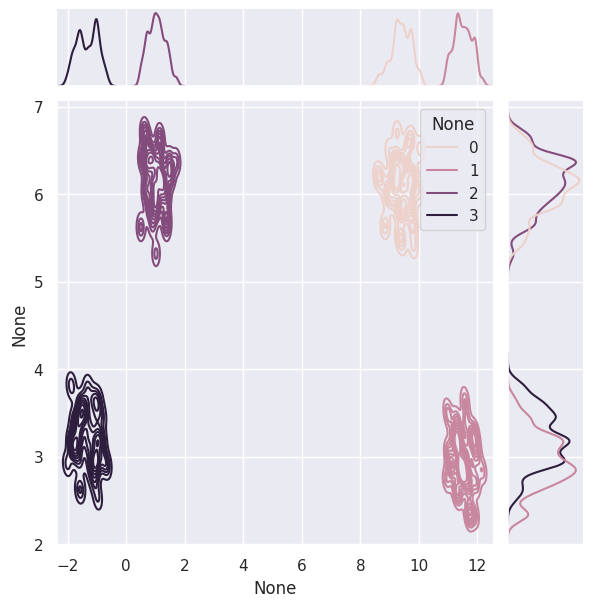

In [15]:
_ = sns.jointplot(
    x=embedding[clustered, 0], y=embedding[clustered, 1], hue=labels[clustered], kind="kde"
)

plt.show()

보시다시피, 이 데이터의 일부 구간에서는 4개의 뚜렷한 섬(islands)이 형성된 것을 확인할 수 있다. 클러스터들은 이러한 밀도를 중심으로 형성되어 있는데, 이것이 바로 DenseClus가 보여주기를 기대했던 동작이다.

밀도가 어떻게 분할되었는지 트리를 시각적으로 그려봄으로써 결과를 더욱 확신할 수 있다.

이것은 앞서 확인한 카운트에 더해, 더 많은 정보를 제공하는 그래픽 형태의 시각화이다. 예를 들어, 두 개의 밀도가 클러스터의 기본적인 분할을 나타내기 때문에, 두 개의 클러스터 솔루션 또한 가능하다는 것을 볼 수 있다.

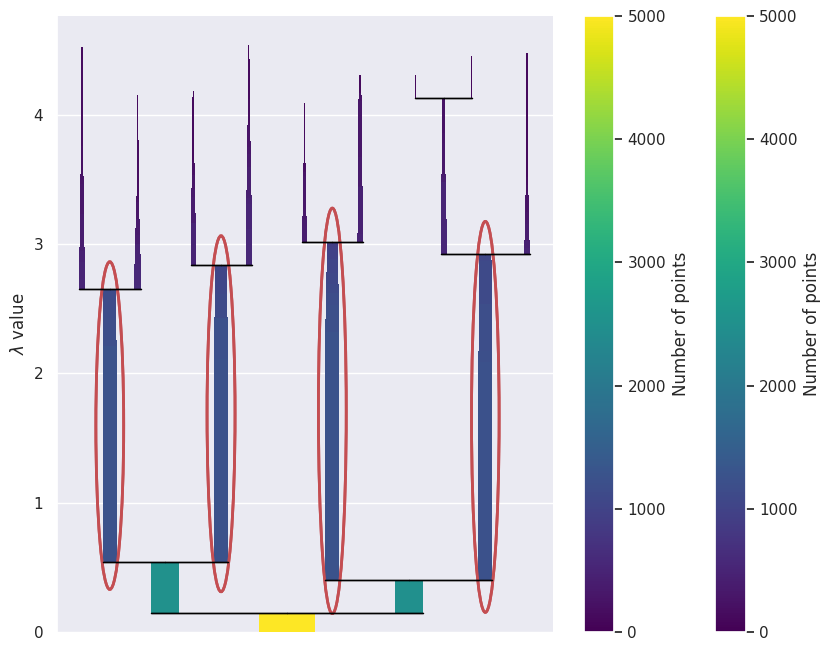

In [17]:
_ = clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(clustered).shape[0]),
)

plt.show()

Lastly, let's confirm that the majority of data points are covered by our clusters and the DBCV score.

In [18]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf.hdbscan_.relative_validity_}")

Coverage 1.0
DBCV score 0.7788391886226897


The DBCV comes between a scale of -1 to 1.

In practice we would want a score over 0.45 to make sure that clusters are well-separated.

## 결론

HDBSCAN의 하이퍼파라미터를 어떻게 튜닝하는지 좀 더 자세히 살펴보는 시간을 즐겼기를 바란다!!!

이번 글에서는, 왜 클러스터링과 그 평가 지표가 복잡해질 수 있는지 알아보았고, DBCV라는 객관적인 평가 지표에 대해 배웠으며, 이를 Amazon Denseclus와 HDBSCAN을 이용해 실제로 적용해 보았다.

여기서는 표면만 살짝 다뤄봤을 뿐이다. 더 깊이 파고들고 싶다면, 다음과 같은 점도 탐구해볼 수 있다:

* Random Search 대신 어떤 종류의 최적화 프레임워크를 사용할 수 있을까?
* 튜닝에 사용할 수 있는 다른 종류의 하이퍼파라미터에는 무엇이 있을까?
* 추가적인 클러스터 검증을 위한 다른 평가 지표는 무엇이 있을까?
* Denseclus 내부의 다른 하이퍼파라미터를 조정해서 더 높은 점수를 얻을 수 있을까?


## References

*"Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis"*, Rousseeuw 1987

*"Density-Based Clustering Validation"*, Moulavi et al. 2014

*"hdbscan: Hierarchical density based clustering In"*, McInnes, J. Healy, S. Astels 2017